In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
# import pyproj ( https://anaconda.org/conda-forge/pyproj ) to calculate distance between coordinates
from pyproj import Geod 
pd.options.display.max_rows = 999

In [2]:
# read data from csv
cities = pd.read_csv("cities.csv")
providers = pd.read_csv("providers.csv")
stations = pd.read_csv("stations.csv")
ticket_data = pd.read_csv("ticket_data.csv")

In [3]:
#view data 
cities.head()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [4]:
#data information
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
id             8040 non-null int64
local_name     8040 non-null object
unique_name    8039 non-null object
latitude       8040 non-null float64
longitude      8040 non-null float64
population     369 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


In [5]:
# summarize data
ticket_data.describe()

,id,company,o_station,d_station,price_in_cents,o_city,d_city
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000


In [6]:
# retaining necessary columns
providers = providers[['name','provider_id','transport_type']]

In [7]:
# providers.dropna(inplace= True)

#convert to numeric data for computation purpose
providers['provider_id'] = pd.to_numeric(providers['provider_id'], errors='coerce',downcast="integer")
# providers['provider_id'] = providers['provider_id'].astype(dtype='int32')

In [8]:
# creating a coordinated column from lat and lon data
stations['coordinates'] = stations[['latitude','longitude']].values.tolist()
stations.head()


,id,unique_name,latitude,longitude,coordinates
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956,"[48.835296, 10.092956]"
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883,"[44.830226, -0.700883]"
2,3,Aéroport CDG,49.009900,2.559310,"[49.0099, 2.55931]"
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345,"[52.389446, 13.520345]"
4,5,Aéroport de Dresden,51.123604,13.764737,"[51.1236038208008, 13.7647371292114]"


In [9]:
# cast date information to datetime
ticket_data['arrival_ts'] = pd.to_datetime(ticket_data['arrival_ts'])
ticket_data['departure_ts'] = pd.to_datetime(ticket_data['departure_ts'])

#calculate travel time
ticket_data['travel_time'] = (ticket_data['arrival_ts'] - ticket_data['departure_ts']).astype('timedelta64[h]')

# retaining useful columns
ticket_data = ticket_data[['company','travel_time','price_in_cents','o_station','d_station','o_city','d_city']]


In [10]:
# merge providers and ticket data 
full_data = ticket_data.merge(providers,left_on="company",right_on="provider_id",how="outer",copy=False)
# full_data.fillna('unknown', inplace=True)

# map coordiates to values  from stations ans city dataframes
full_data['o_station'] = full_data['o_station'].map(stations.set_index('id')['coordinates'])
full_data['d_station'] = full_data['d_station'].map(stations.set_index('id')['coordinates'])
full_data['o_city'] = full_data['o_city'].map(cities.set_index('id')['local_name'])
full_data['d_city'] = full_data['d_city'].map(cities.set_index('id')['local_name'])

#Fill NAN with "unknown"
full_data.fillna('unknown', inplace=True)

full_data.head()

,company,travel_time,price_in_cents,o_station,d_station,o_city,d_city,name,provider_id,transport_type
0,8385,6,4550,unknown,unknown,"Orléans, Centre-Val de Loire, France","Montpellier, Occitanie, France",unknown,unknown,unknown
1,8385,3,1800,unknown,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,unknown,unknown
2,8385,2,2150,unknown,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,unknown,unknown
3,8385,2,1700,unknown,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,unknown,unknown
4,8385,2,1700,unknown,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,unknown,unknown


In [11]:
geod = Geod(ellps='WGS84') 

#Get distance between pairs of lat-lon points
def Distance(coord1,coord2):
    # verify datatype to handle "unknown" origin and destinations
    if isinstance(coord1, list) & isinstance(coord2, list):
        az12,az21,dist = geod.inv(coord1[1],coord1[0],coord2[1],coord2[0]) 
        return dist/1000
    else:
        return 0

In [12]:
# create distance column
full_data['distance'] = full_data.apply(lambda row : Distance(row['o_station'], row['d_station']), axis = 1) 

In [13]:
# convert price to from cents to euros
full_data['price'] =  pd.to_numeric(full_data['price_in_cents'], errors='coerce')/100

# convert trael_time to numeric for computation
full_data['travel_time'] =  pd.to_numeric(full_data['travel_time'], errors='coerce')

# drop unnecessary columns
full_data.drop(['o_station','d_station','provider_id','price_in_cents'],axis=1,inplace=True)

In [14]:
#calculate range of distance
def calc_range(dist):
    if 0<= dist <= 200:
        return "0-200" 
    elif 201 <= dist <= 800:
        return "201-800"
    elif 801 <= dist <= 2000:
        return "801-2000"
    elif 2001 <= dist:
        return "2000+"

#create "range column"
full_data['range'] = full_data.apply(lambda row : calc_range(row['distance']), axis = 1) 

In [15]:
#reorganise data for interpretability
full_data = full_data[['company','name','o_city','d_city','transport_type','price','travel_time','distance','range']]
full_data.dropna()


,company,name,o_city,d_city,transport_type,price,travel_time,distance,range
0,8385,unknown,"Orléans, Centre-Val de Loire, France","Montpellier, Occitanie, France",unknown,45.50,6.0,0.000000,0-200
1,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,18.00,3.0,0.000000,0-200
2,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,21.50,2.0,0.000000,0-200
3,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,17.00,2.0,0.000000,0-200
4,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,17.00,2.0,0.000000,0-200
5,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,19.00,2.0,0.000000,0-200
6,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,15.50,3.0,0.000000,0-200
7,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,14.50,2.0,0.000000,0-200
8,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,15.50,2.0,0.000000,0-200
9,8385,unknown,"Paris, Île-de-France, France","Lille, Hauts-de-France, France",unknown,15.50,2.0,0.000000,0-200


### Price,duration and distance data by route and provider
   ##### This can be implemented as 
   #####  1: A function, to return data for user input of cities.
   ##### 2: Exported as excel sheet

In [16]:
#showing min,max,avg price, duration and distance between cities and provider
price_by_route = full_data.groupby(['o_city','d_city','name']).agg({'price':[pd.np.min, pd.np.max, pd.np.mean],'travel_time':[pd.np.min, pd.np.max, pd.np.mean],'distance':[pd.np.min, pd.np.max, pd.np.mean]})
price_by_route.head(100)

price  \
                                                                                                                 amin   
o_city                                             d_city                                             name              
Agde, Occitanie, France                            Amsterdam, Noord-Holland, Nederland                unknown  186.00   
Agen, Nouvelle-Aquitaine, France                   Dijon, Bourgogne-Franche-Comté, France             unknown   98.60   
                                                   Marseille Aéroport, Provence-Alpes-Côte d'Azur,... unknown   37.00   
                                                   Marseille, Provence-Alpes-Côte d'Azur, France      unknown   20.00   
                                                   Paris, Île-de-France, France                       unknown   26.00   
                                                   Toulouse, Occitanie, France                        unknown    7.00   
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Angers, Pays-de-la-Loire, France                   unknown   50.90   
                                                   Annecy, Auvergne-Rhône-Alpes, France               unknown   20.00   
                                                   Annemasse, Auvergne-Rhône-Alpes, France            unknown   31.00   
                                                   Clermont-Ferrand, Auvergne-Rhône-Alpes, France     unknown   23.90   
                                                   Genève, Genève, Schweiz                            unknown   26.50   
                                                   La Rochelle, Nouvelle-Aquitaine, France            unknown   16.00   
                                                   Lille, Hauts-de-France, France                     corail    48.90   
                                                                                                      unknown   57.00   
                                                   Lyon, Auvergne-Rhône-Alpes, France                 unknown   14.00   
                                                   Metz, Grand-Est, France                            unknown   27.90   
                                                   Nice, Provence-Alpes-Côte d'Azur, France           unknown   11.00   
                                                   Paris, Île-de-France, France                       corail    16.00   
                                                                                                      unknown   19.00   
                                                   Perpignan, Occitanie, France                       unknown   12.00   
                                                   Saint-Raphaël, Provence-Alpes-Côte d'Azur, France  unknown   14.00   
                                                   Terrasson, Nouvelle-Aquitaine, France              unknown   35.00   
                                                   Thionville, Grand-Est, France                      unknown   57.00   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France         corail    18.90   
                                                                                                      unknown    5.00   
                                                   Valencia, Comunitat Valenciana, España             unknown   61.50   
Albias, Occitanie, France                          Brive-la-Gaillarde, Nouvelle-Aquitaine, France     unknown   12.00   
Alençon, Normandie, France                         Nantes, Pays-de-la-Loire, France                   unknown   17.00   
Alpe d'Huez, Auvergne-Rhône-Alpes, France          Bordeaux, Nouvelle-Aquitaine, France               unknown   45.50   
Alès, Occitanie, France                            Lyon, Auvergne-Rhône-Alpes, France                 unknown   18.00   
                                                   Marseille, Provence-Alpes-Côte d'Azur, France      unknown   12.00  

### Analyse data for provider "CORAIL"

In [17]:
corail_data = price_by_route.xs('corail', level=2)
corail_data.head()

price  \
                                                                                                       amin   
o_city                                             d_city                                                     
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Lille, Hauts-de-France, France                      48.9   
                                                   Paris, Île-de-France, France                        16.0   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France          18.9   
Amiens, Hauts-de-France, France                    Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr...  35.0   
                                                   Bordeaux, Nouvelle-Aquitaine, France                20.9   

                                                                                                             \
                                                                                                       amax   
o_city                                             d_city                                                     
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Lille, Hauts-de-France, France                      48.9   
                                                   Paris, Île-de-France, France                        26.9   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France          18.9   
Amiens, Hauts-de-France, France                    Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr...  42.9   
                                                   Bordeaux, Nouvelle-Aquitaine, France                40.9   

                                                                                                               \
                                                                                                         mean   
o_city                                             d_city                                                       
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Lille, Hauts-de-France, France                      48.900   
                                                   Paris, Île-de-France, France                        22.925   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France          18.900   
Amiens, Hauts-de-France, France                    Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr...  38.950   
                                                   Bordeaux, Nouvelle-Aquitaine, France                28.450   

                                                                                                      travel_time  \
                                                                                                             amin   
o_city                                             d_city                                                           
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Lille, Hauts-de-France, France                            20.0   
                                                   Paris, Île-de-France, France                              11.0   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France                14.0   
Amiens, Hauts-de-France, France                    Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr...        15.0   
                                                   Bordeaux, Nouvelle-Aquitaine, France                      12.0   

                                                                                                             \
                                                                                                       amax   
o_city                                             d_city                                                     
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Lille, Hauts-de-France, France                      20.0   
                                      

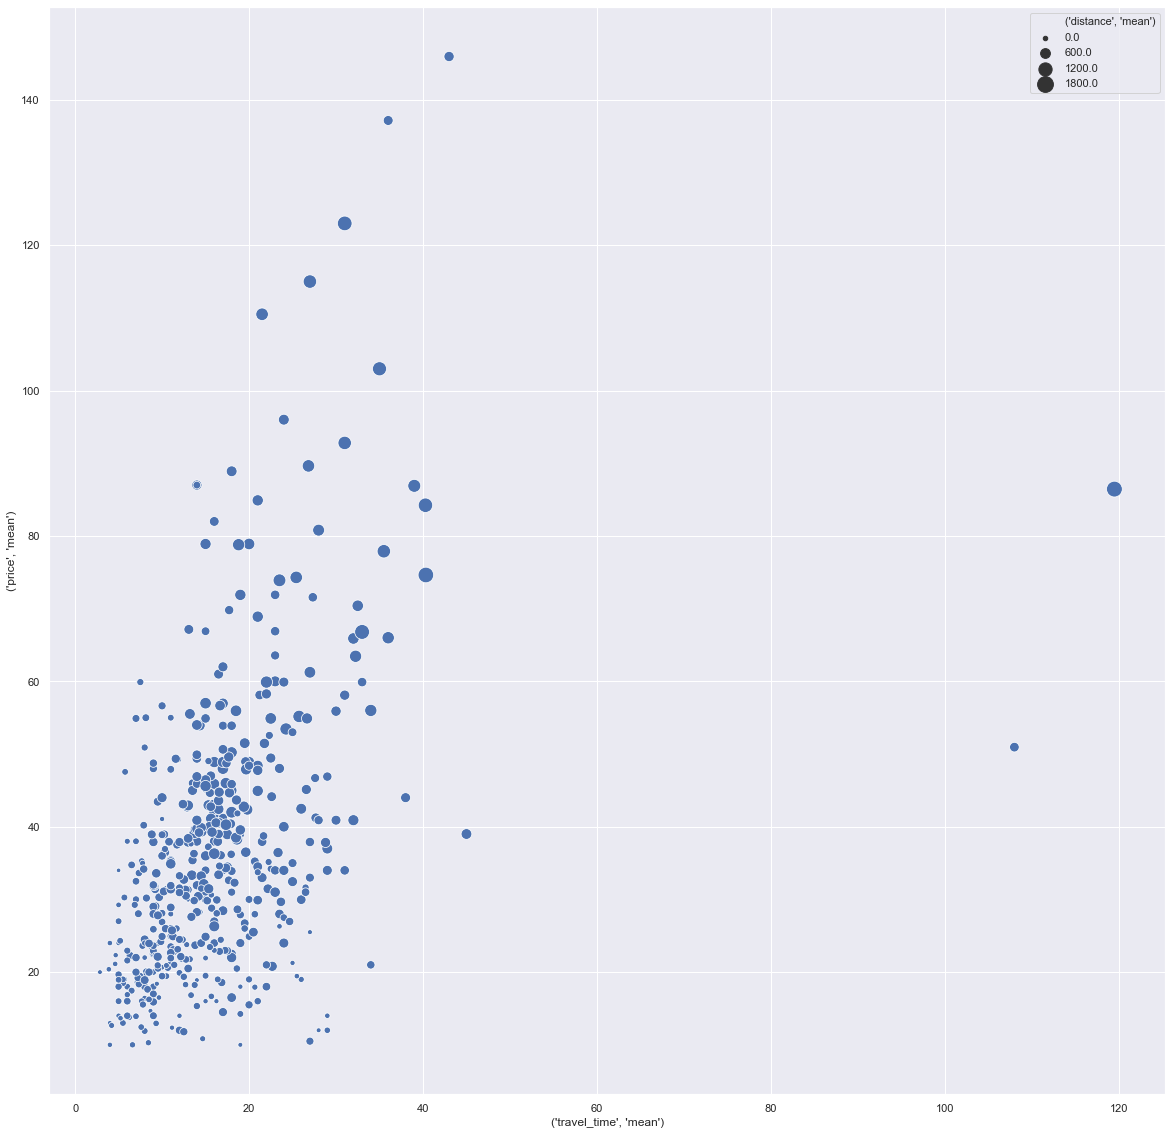

In [18]:
sns.set(rc={'figure.figsize':(20,20)})
ax = sns.scatterplot(y=corail_data[('price', 'mean')], x=corail_data[('travel_time', 'mean')],
                     size=corail_data[('distance', 'mean')],
                      sizes=(20, 250))

# plot observation
###### 1) huge variation in price for the segment with travel times 0-20,with distances less than 600
###### 2) general Linear trend in distance, travel time and price

#### Price and duration data by mode of transport

In [19]:
#showing price by mode of transport 
price_by_mode = full_data.groupby(['o_city','d_city','transport_type']).agg({'price':[pd.np.min, pd.np.max, pd.np.mean],'travel_time':[pd.np.min, pd.np.max, pd.np.mean]})
price_by_mode.dropna().head(10000)

price  \
                                                                                                                        amin   
o_city                                             d_city                                             transport_type           
Agde, Occitanie, France                            Amsterdam, Noord-Holland, Nederland                unknown         186.00   
Agen, Nouvelle-Aquitaine, France                   Dijon, Bourgogne-Franche-Comté, France             unknown          98.60   
                                                   Marseille Aéroport, Provence-Alpes-Côte d'Azur,... unknown          37.00   
                                                   Marseille, Provence-Alpes-Côte d'Azur, France      unknown          20.00   
                                                   Paris, Île-de-France, France                       unknown          26.00   
                                                   Toulouse, Occitanie, France                        unknown           7.00   
Aix-en-provence, Provence-Alpes-Côte d'Azur, Fr... Angers, Pays-de-la-Loire, France                   unknown          50.90   
                                                   Annecy, Auvergne-Rhône-Alpes, France               unknown          20.00   
                                                   Annemasse, Auvergne-Rhône-Alpes, France            unknown          31.00   
                                                   Clermont-Ferrand, Auvergne-Rhône-Alpes, France     unknown          23.90   
                                                   Genève, Genève, Schweiz                            unknown          26.50   
                                                   La Rochelle, Nouvelle-Aquitaine, France            unknown          16.00   
                                                   Lille, Hauts-de-France, France                     train            48.90   
                                                                                                      unknown          57.00   
                                                   Lyon, Auvergne-Rhône-Alpes, France                 unknown          14.00   
                                                   Metz, Grand-Est, France                            unknown          27.90   
                                                   Nice, Provence-Alpes-Côte d'Azur, France           unknown          11.00   
                                                   Paris, Île-de-France, France                       train            16.00   
                                                                                                      unknown          19.00   
                                                   Perpignan, Occitanie, France                       unknown          12.00   
                                                   Saint-Raphaël, Provence-Alpes-Côte d'Azur, France  unknown          14.00   
                                                   Terrasson, Nouvelle-Aquitaine, France              unknown          35.00   
                                                   Thionville, Grand-Est, France                      unknown          57.00   
                                                   Toulon, Provence-Alpes-Côte d'Azur, France         train            18.90   
                                                                                                      unknown           5.00   
                                                   Valencia, Comunitat Valenciana, España             unknown          61.50   
Albias, Occitanie, France                          Brive-la-Gaillarde, Nouvelle-Aquitaine, France     unknown          12.00   
Alençon, Normandie, France                         Nantes, Pays-de-la-Loire, France                   unknown          17.00   
Alpe d'Huez, Auvergne-Rhône-Alpes, France          Bordeaux, Nouvelle-Aquitaine, France               unknown          45.50   
Alès, Occitanie, France

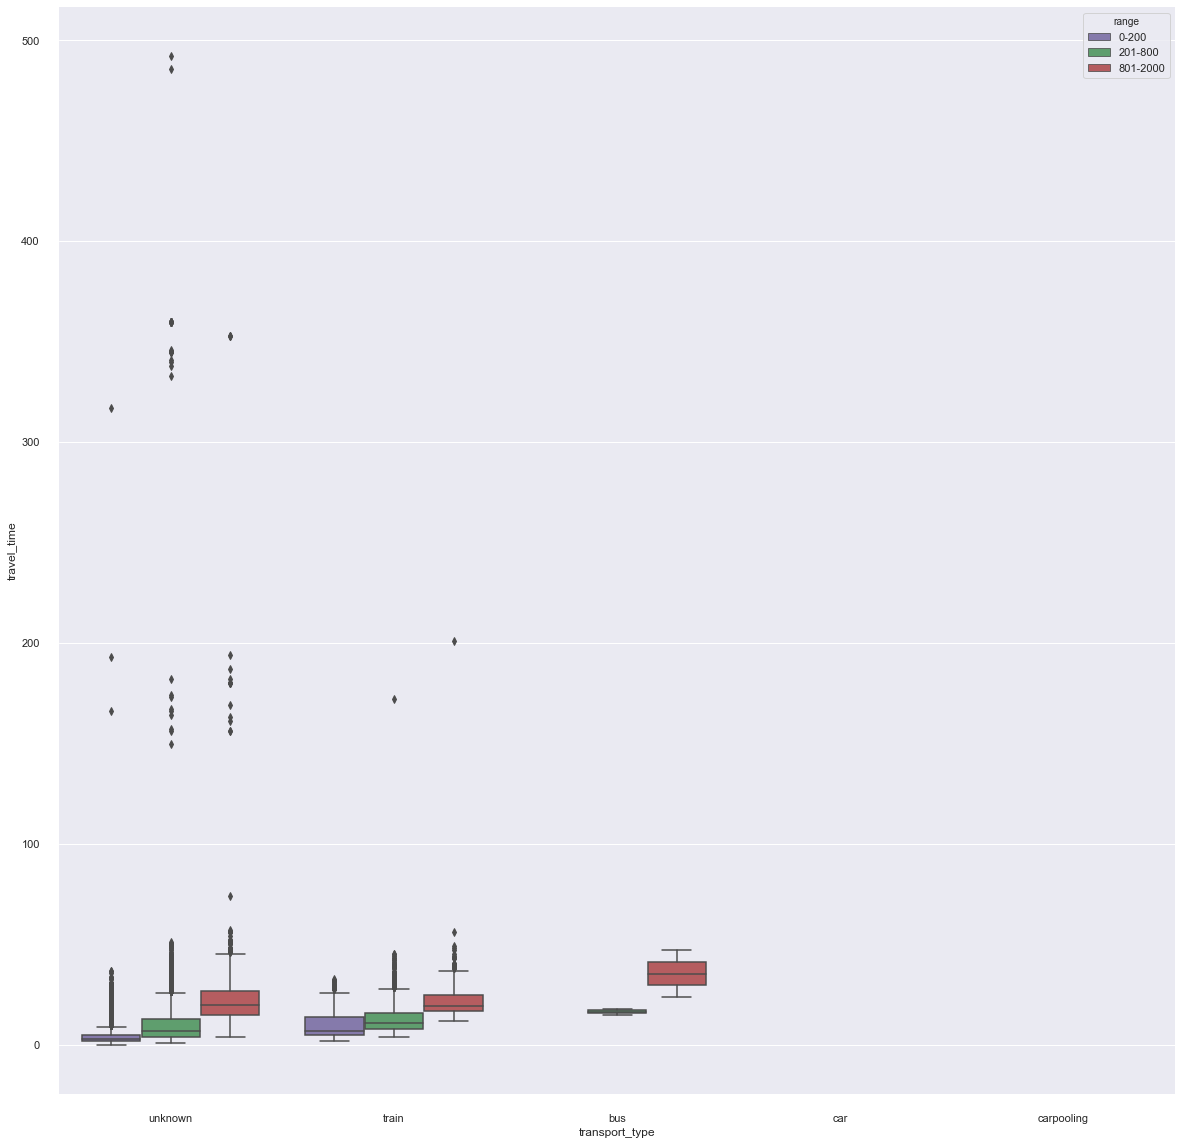

In [38]:
sns.boxplot(x=full_data['transport_type'], y=full_data["travel_time"],
            hue=full_data["range"], palette=["m", "g","r"])
            
sns.despine(offset=10, trim=True)

#### price by distance

In [34]:
#showing prices by transport type and distance range
price_by_distance = full_data.groupby(['transport_type','range']).agg({'price':[pd.np.min, pd.np.max, pd.np.mean]})
# price_by_distance.reset_index(inplace=True)

price_by_distance.head(20)

price                    
                          amin    amax        mean
transport_type range                              
bus            0-200       NaN     NaN         NaN
               201-800   38.29   41.30   39.795000
               801-2000  71.40  163.95  117.675000
car            0-200       NaN     NaN         NaN
carpooling     0-200       NaN     NaN         NaN
train          0-200      8.50   58.90   19.671908
               201-800   10.00  145.96   34.047163
               801-2000  22.90  128.90   61.127103
unknown        0-200      3.00  251.00   27.816824
               201-800   10.00  385.50   72.560929
               801-2000  30.00  375.50   93.926390

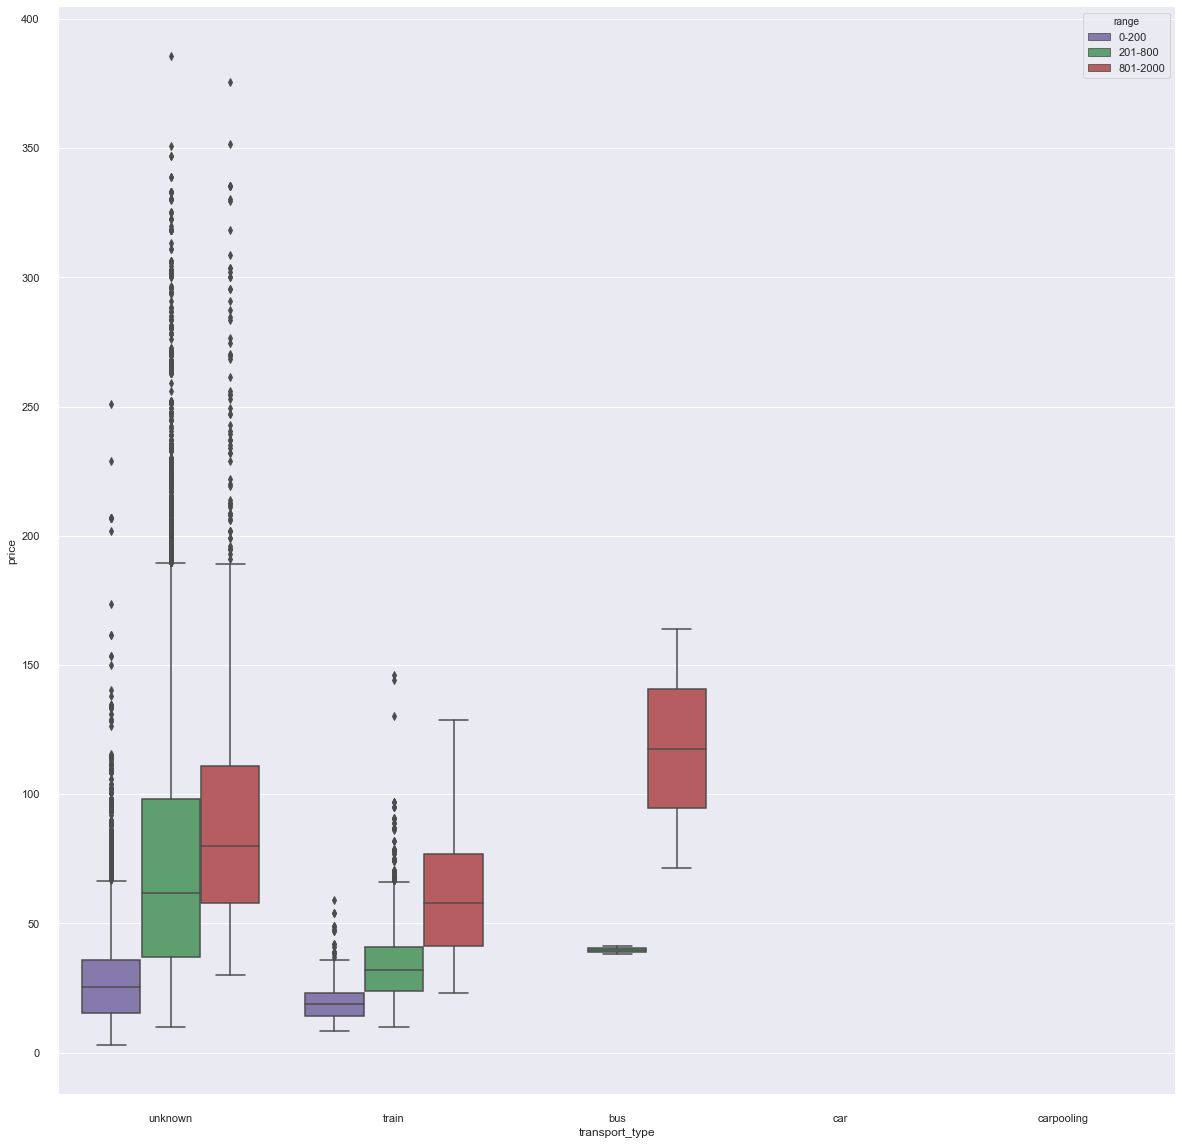

In [33]:
sns.boxplot(x=full_data['transport_type'], y=full_data["price"],
            hue=full_data["range"], palette=["m", "g","r"])
            
sns.despine(offset=10, trim=True)

### Future improvement :
 ####   handle NAN in distance range data. verify the cause of NAN and choose appropritae method to impute